# Investigation of performance of net mechanism on a two-dimensional toy data set

In [28]:
import second_moment_experiments_main as experiment
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
from exputils import extract_data, initialise_netmech_containers, initialise_adassp_reg_containers, \
initialise_netmech_reg_containers, get_expected_statistics, get_optimal_utilities_statistics
from baselines import Regression, DPRegression
import numpy as np
# %matplotlib tk

In [4]:
# Load data 
exp_name = 'exp_vary_private_data_extended_targets_3'
with open ('D:/Thesis/Experiments/exp_vary_private_data_extended_targets_3/' + exp_name, "rb") as container:
    results = pickle.load(container)

## Assess the performance of the netmechanism for sparse lattices for a wide range of datasets

$\textbf{Setup}$: Draw $25$ samples with the net mechanism set up with $k_t =3, k_f \in \{3,...,20\}$ for $100$ different data sets.  Compare the expected average RMSE across the $100$ datasets with the results obtained originally for the seed = 23 case. Then compute the expected average RMSE across the $100$ datasets for the ADASSP algorithm and compare the two.

### Parameter setup

In [29]:
# Default parameters list
dimensionality = 2
num_records = 300
test_frac = 0.8
batch_size = 1000
directory = 'D:/Thesis/Experiments/exp_vary_private_data_extended_targets_3/'
parallel = True
save_data = False
partition_method = 'fast_2'
workers = 3
num_samples = 25
sample_parallel = False 
load_data = False
num_points_targets = 3

In [30]:
# Experiment specific
num_points_min = 3
min_seed = 0
num_points_max = 20
num_points_features_vec = range(num_points_min, num_points_max + 1)
num_datasets = 100
epsilon_vec = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

### Run the experiments

In [ ]:
# Initialise results data containers
results = {key_outer: {key_inner : [] for key_inner in epsilon_vec}  for key_outer in range(num_datasets)}

In [ ]:
# Collect results
for dataset in range(min_seed, num_datasets):
    print ("Dataset number", dataset)
    for epsilon in epsilon_vec:
        for num_points_features in num_points_features_vec:
            results[dataset][epsilon].append(experiment.second_order_moment_experiment(dimensionality = dimensionality, num_records = num_records, \
                                                                                       test_frac = test_frac, batch_size = batch_size,directory = directory, \
                                                                                       parallel = parallel, save_data = save_data,\
                                                                                       partition_method = partition_method, workers = workers, \
                                                                                       num_samples = num_samples, sample_parallel = sample_parallel,\
                                                                                       load_data = load_data, num_points_targets = num_points_targets,\
                                                                                       num_points_features = num_points_features, epsilon = epsilon, \
                                                                                       seed = dataset))

In [ ]:
# Save the results for latter access
exp_name = 'exp_vary_private_data_extended_targets_3'
with open (directory + exp_name, "wb") as container:
    pickle.dump(results, container)

## Analyse the data

In [7]:
# Experimental data containers
max_utilities, avg_samples_utility, synthetic_datasets_vec, test_set, private_data = \
    initialise_netmech_containers(epsilon_vec, multiple_datasets = True, max_dataset = num_datasets)

In [8]:
# Extract data from the results data structure 
for dataset_number in results.keys():
    # Quantities that are epsilon independent 
    fixed_eps = 0.1
    max_utilities[dataset_number], test_set[dataset_number],private_data[dataset_number] = extract_data(results[dataset_number][fixed_eps],\
                                                                                                    multiple_datasets = True, \
                                                                                                    max_dataset = num_datasets, \
                                                                                                    eps_dependent = False)
    # Quantities that are epsilon independent
    for epsilon in results[dataset_number].keys():
        avg_samples_utility[dataset_number][epsilon], synthetic_datasets_vec[dataset_number][epsilon] = \
           extract_data(results[dataset_number][epsilon], multiple_datasets = True, max_dataset = num_datasets, \
                          eps_dependent = True) 

In [9]:
# Initialise containers for the regression on the synthetic data sets released with netmechanism
net_mech_reg_coefs, predictive_errs_netmech, min_predictive_errs_netmech, mean_predictive_errs_netmech,\
double_std_predictive_errs_netmech = initialise_netmech_reg_containers(epsilon_vec, multiple_datasets = True,\
                                                                        max_dataset = num_datasets)

# Initialise containers for the regression on the synthetic data sets with parameters released by ADASSP
adassp_reg_coef, predictive_err_adassp, min_predictive_err_adassp, mean_predictive_err_adassp, double_std_predictive_err_adassp\
                                   = initialise_adassp_reg_containers(epsilon_vec, multiple_datasets = True, max_dataset = num_datasets)

In [10]:
# Fit ADASSP to the private dataset and calculate the predictive error
for dataset_number in results.keys():
    for epsilon in results[dataset_number].keys():
        adassp_regressor = DPRegression()
        adassp_reg_coef[dataset_number][epsilon] = adassp_regressor.get_parameters(private_data[dataset_number].features, \
                                                                                   private_data[dataset_number].targets,\
                                                                                   num_samples, epsilon, seed = dataset_number)
        predictive_err_adassp[dataset_number][epsilon] = Regression().calculate_predictive_error(private_data[dataset_number].test_data, \
                                                                                                 adassp_reg_coef[dataset_number][epsilon])
        min_predictive_err_adassp[dataset_number][epsilon] = np.min(predictive_err_adassp[dataset_number][epsilon])
        mean_predictive_err_adassp[dataset_number][epsilon] = np.mean(predictive_err_adassp[dataset_number][epsilon])
        double_std_predictive_err_adassp[dataset_number][epsilon] = 2*np.std(predictive_err_adassp[dataset_number][epsilon])

In [11]:
# Perform regression on the datasets released with the net mechanism and calculate predictive error statistics
for dataset_number in results.keys():
    for epsilon in results[dataset_number].keys():
        for synthetic_datasets in synthetic_datasets_vec[dataset_number][epsilon]:
            netmech_regressor = Regression()
            net_mech_reg_coef = netmech_regressor.fit_data(synthetic_datasets)
            net_mech_reg_coefs[dataset_number][epsilon].append(net_mech_reg_coef)
            predictive_err_netmech = netmech_regressor.calculate_predictive_error(private_data[dataset_number].test_data, \
                                                                                  net_mech_reg_coef)
            predictive_errs_netmech[dataset_number][epsilon].append(predictive_err_netmech)
            min_predictive_errs_netmech[dataset_number][epsilon].append(np.min(predictive_err_netmech))
            mean_predictive_errs_netmech[dataset_number][epsilon].append(np.mean(predictive_err_netmech))
            double_std_predictive_errs_netmech[dataset_number][epsilon].append(2*np.std(predictive_err_netmech))

C:\Users\alexc\OneDrive\Documents\GitHub\Thesis\baselines.py:121: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  parameters[index] = np.linalg.lstsq(Sigma_tensor[index,:,:], correlations[index])[0]


In [12]:
# Calculate the desired satistics           
expected_avg_utility, min_avg_utility, max_avg_utility, expected_mean_predictive_errs_netmech, \
expected_double_std_predictive_errs_netmech, expected_mean_predictive_err_adassp, \
expected_double_std_predictive_err_adassp, expected_min_predictive_errs_netmech, \
min_min_predictive_errs_netmech, max_min_predictive_errs_netmech, expected_min_predictive_err_adassp, \
min_min_predictive_err_adassp, max_min_predictive_err_adassp = get_expected_statistics(avg_samples_utility,\
                                                                    mean_predictive_errs_netmech,\
                                                                    double_std_predictive_errs_netmech,\
                                                                    mean_predictive_err_adassp,\
                                                                    double_std_predictive_err_adassp, \
                                                                    min_predictive_errs_netmech, \
                                                                    min_predictive_err_adassp, \
                                                                    epsilon_vec)
expected_optimal_utilities, min_optimal_utilities, max_optimal_utilities = get_optimal_utilities_statistics(max_utilities)

## Plot the results

In [13]:
xcoordinate = num_points_features_vec
# Define the range of epsilon for which various quntities are plotted
epsilon_range = [0.1, 0.6, 5.0]

#### Expected average samples utility

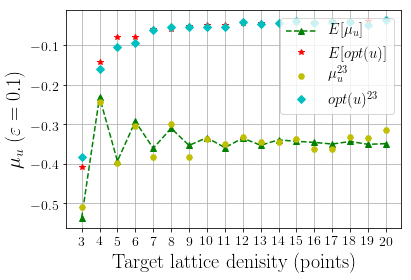

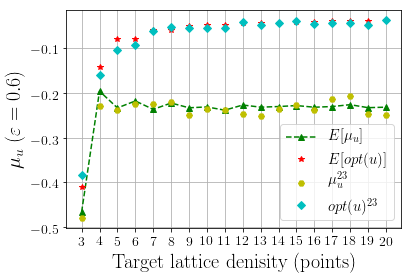

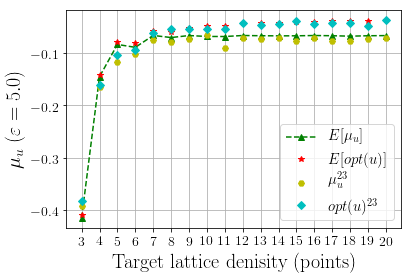

In [14]:
def plot_expected_avg_utility(xcoordinate, expected_avg_samples_utility, expected_optimal_utilities, epsilon):
    plt.plot(xcoordinate, expected_avg_samples_utility, 'g--^', label = r'$E[\mu_u]$' )
    plt.plot(xcoordinate, expected_optimal_utilities, 'r*', label = r'$E[opt(u)]$')
    plt.xticks(xcoordinate)
    plt.xlabel('Target lattice denisity (points)', fontsize = 20)
    plt.ylabel(r'$\mu_u$ ($\varepsilon =' + str(epsilon) + '$)', fontsize = 20)
    plt.legend(fontsize = 15)
    plt.grid(True)

for epsilon in epsilon_range:
    plot_expected_avg_utility(xcoordinate, expected_avg_utility[epsilon],\
                            expected_optimal_utilities, epsilon)
    plt.plot(xcoordinate, avg_samples_utility[23][epsilon], 'yH', label = r'$\mu_u^{23}$')
    plt.plot(xcoordinate, max_utilities[23], 'cD', label = r'$opt(u)^{23}$')
    plt.legend(fontsize = 15)
    plt.show()
    

#### Variation of average RMSE with $\varepsilon$ for various lattice densities

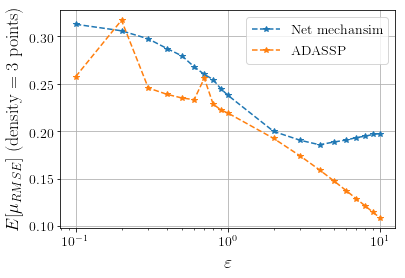

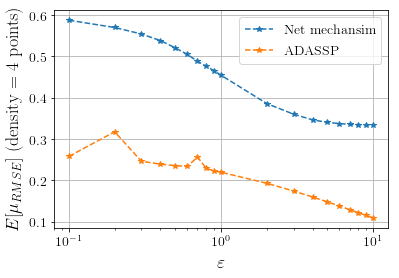

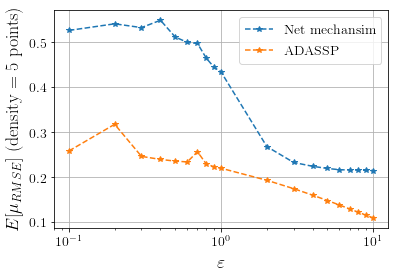

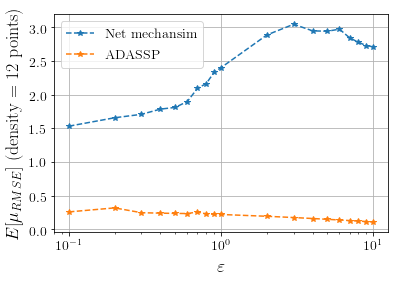

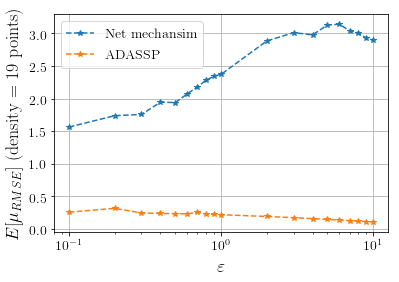

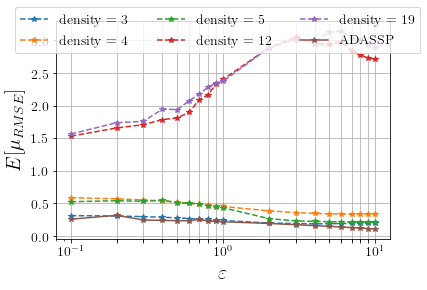

In [20]:
# Calculate variation of RMSE as a function of epsilon
expected_rmse_eps_avg_netmech = {key: [] for key in xcoordinate}
expected_rmse_eps_std_netmech = {key: [] for key in xcoordinate}
expected_rmse_eps_avg_adassp = []
expected_prmse_eps_std_adassp = []

# Extract data
for epsilon in epsilon_vec[0: len(epsilon_vec)]:
    # print ("DEBUG:", mean_predictive_errs_netmech[epsilon])
    # print ("DEBUG:", len(mean_predictive_errs_netmech[epsilon]))
    for index in xcoordinate:
        expected_rmse_eps_avg_netmech[index].append(expected_mean_predictive_errs_netmech[epsilon][index - xcoordinate[0]])
        expected_rmse_eps_std_netmech[index].append(expected_double_std_predictive_errs_netmech[epsilon][index - xcoordinate[0]])

expected_rmse_eps_avg_adassp = [expected_mean_predictive_err_adassp[epsilon] for epsilon in epsilon_vec[0: len(epsilon_vec)]] 
expected_rmse_eps_std_adassp = [expected_double_std_predictive_err_adassp[epsilon] for epsilon in epsilon_vec[0: len(epsilon_vec)]]

def plot_expected_rmse_avg_epsilon(epsilon_vec, expected_rmse_eps_avg_netmech, expected_rmse_eps_avg_adassp, lattice_density,\
                                   adassp = True):
    plt.semilogx(epsilon_vec, expected_rmse_eps_avg_netmech, '--*', label = 'Net mechansim')
    if adassp:
        plt.plot(epsilon_vec, expected_rmse_eps_avg_adassp, '--*', label = 'ADASSP')
        # plt.ylim([0, 1.5]) 
    plt.xlabel(r'$\varepsilon$', fontsize = 18)
    # plt.yticks(np.arange(0,1.5, step = 0.1))
   #  plt.xticks(epsilon_vec)
    plt.ylabel('$E[\mu_{RMSE}]$ (density = ' + str(lattice_density) +  ' points)', fontsize = 18)
    plt.legend(fontsize = 14)
    plt.grid(True)
    plt.show()

xcoordinate_range = [3, 4, 5, 12, 19]

for lattice_density in xcoordinate_range:
    # print ("DEBUG, rmse_eps_avg_netmech", rmse_eps_avg_netmech[lattice_density])
    plot_expected_rmse_avg_epsilon(epsilon_vec[0: len(epsilon_vec)], expected_rmse_eps_avg_netmech[lattice_density],\
                                   expected_rmse_eps_avg_adassp, lattice_density, adassp = True)
    
# Plot average RMSE for ADASSP for selected values of the lattice density on the same graph
plt.figure(1)

#xcoordinate_range = xcoordinate
for lattice_density in xcoordinate_range:
    plt.semilogx(epsilon_vec[0: len(epsilon_vec)], expected_rmse_eps_avg_netmech[lattice_density], '--*', \
                 label = 'density = ' + str(lattice_density))
plt.plot(epsilon_vec[0: len(epsilon_vec)], expected_rmse_eps_avg_adassp,'-*', label = 'ADASSP')
plt.xlabel(r'$\varepsilon$', fontsize = 20)
plt.ylabel('$E[\mu_{RMSE}]$', fontsize = 20)
plt.xticks(epsilon_vec[0: len(epsilon_vec)])
#plt.yticks(np.arange(0,3, step = 0.25))
#plt.ylim([0, 3]) 
plt.grid(True)
plt.legend(fontsize = 14, bbox_to_anchor=(0.5, 0.85), bbox_transform = plt.gcf().transFigure, loc = 'center', ncol = 3)
plt.show()

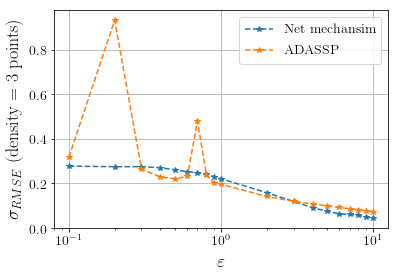

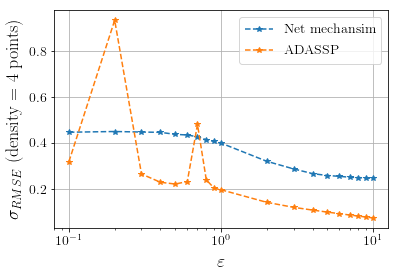

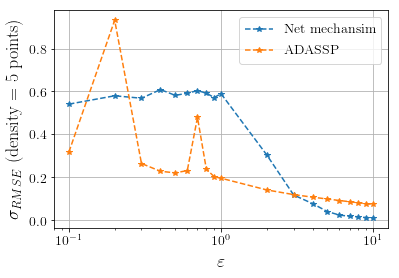

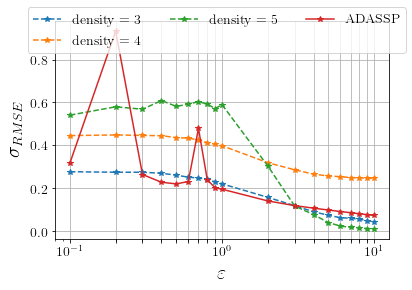

In [21]:
def plot_expected_rmse_std_epsilon(epsilon_vec, expected_rmse_eps_std_netmech, expected_rmse_eps_std_adassp, lattice_density,\
                                   adassp = True):
    plt.semilogx(epsilon_vec, expected_rmse_eps_std_netmech, '--*', label = 'Net mechansim')
    if adassp:
        plt.plot(epsilon_vec, expected_rmse_eps_std_adassp, '--*', label = 'ADASSP')
        # plt.ylim([0, 1]) 
    plt.xlabel(r'$\varepsilon$', fontsize = 18)
   # plt.yticks(np.arange(0,5, step = 1))
   # plt.ylim([0, 5])
   #  plt.xticks(epsilon_vec)
    plt.ylabel(r'$\sigma_{RMSE}$ (density = ' + str(lattice_density) +  ' points)', fontsize = 18)
    plt.legend(fontsize = 14)
    plt.grid(True)
    plt.show()
    
xcoordinate_range = [3, 4, 5]

for lattice_density in xcoordinate_range:
    # print ("DEBUG, expected_rmse_eps_std_netmech", expected_rmse_eps_std_netmech[lattice_density])
    plot_expected_rmse_std_epsilon(epsilon_vec[0: len(epsilon_vec)], expected_rmse_eps_std_netmech[lattice_density],\
                          expected_rmse_eps_std_adassp, lattice_density, adassp = True)

# Plot average RMSE for ADASSP for selected values of the lattice density on the same graph
plt.figure(1)

for lattice_density in xcoordinate_range:
    plt.semilogx(epsilon_vec[0: len(epsilon_vec)], expected_rmse_eps_std_netmech[lattice_density], '--*',\
                 label = 'density = ' + str(lattice_density))
plt.plot(epsilon_vec[0: len(epsilon_vec)], expected_rmse_eps_std_adassp,'-*', label = 'ADASSP')
plt.xlabel(r'$\varepsilon$', fontsize = 20)
plt.ylabel(r'$\sigma_{RMSE}$', fontsize = 20)
plt.xticks(epsilon_vec[0: len(epsilon_vec)])
#plt.yticks(np.arange(0, 10, step = 1))
#plt.ylim([0, 10]) 
plt.grid(True)
plt.legend(fontsize = 14, bbox_to_anchor=(0.5, 0.85), bbox_transform = plt.gcf().transFigure, loc = 'center', ncol = 3)
plt.show()

#### Optimal utility

In [17]:
print(expected_optimal_utilities)

[-0.40963497 -0.14281699 -0.07878355 -0.0804756  -0.05901866 -0.05983875
 -0.05145312 -0.04912275 -0.04861366 -0.04376549 -0.04346062 -0.04318561
 -0.04121859 -0.04129191 -0.03952322 -0.03912336 -0.03926902 -0.03784032]


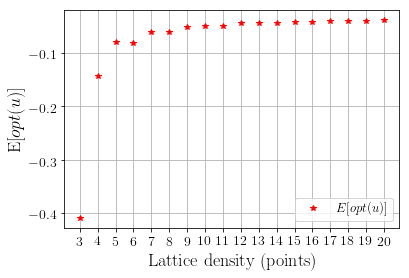

In [18]:
# Independent of epsilon, all the experiments return the same utility
plt.plot(xcoordinate, expected_optimal_utilities, 'r*', label = r'$E[opt(u)]$')
#plt.plot(xcoordinate, max_utilities[23], 'cD', label = r'$opt(u)_{23}$')
#plt.plot(xcoordinate, min_optimal_utilities, 'Xk', label =r'$\min(opt(u))$' )
#plt.plot(xcoordinate, max_optimal_utilities, 'Xr', label =r'$\max(opt(u))$' )
plt.xticks(xcoordinate)
# plt.yticks(np.arange(-0.07, 0.0, step = 0.01))
plt.xlabel('Lattice density (points)', fontsize = 18)
plt.ylabel(r'E[$opt(u)]$', fontsize = 18)
# plt.ylim([-0.07,0])
plt.grid(True)
plt.legend(fontsize = 13)
plt.show()

#### Expected minimum sample error for ADASSP vs netmechanism

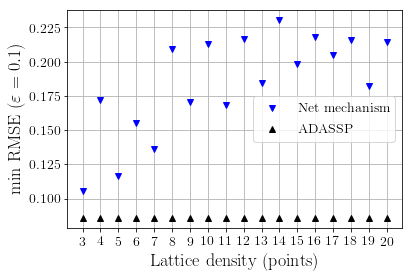

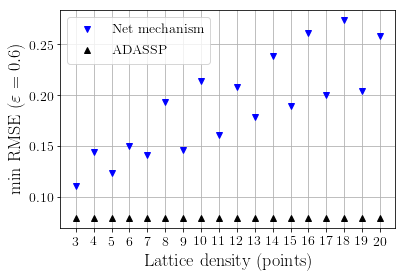

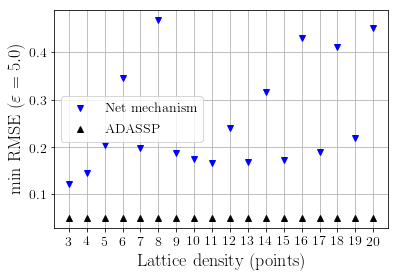

In [23]:
def plot_expected_min_rmses(xcoordinate, expected_min_predictive_errs_netmech, expected_min_predictive_err_adassp, epsilon):
    plt.plot(xcoordinate, expected_min_predictive_errs_netmech, 'bv', label = 'Net mechanism',  )
    plt.plot(xcoordinate, [expected_min_predictive_err_adassp]*len(xcoordinate), 'k^', label = 'ADASSP')
    plt.xlabel('Lattice density (points)', fontsize = 18)
    plt.ylabel(r'$\min$ RMSE ($\varepsilon =' + str(epsilon) + '$)', fontsize = 18)
    plt.xticks(xcoordinate)
    plt.legend(fontsize = 14)
    plt.grid(True)
    plt.show()
epsilon_range = [0.1,0.6,5.0]
for epsilon in epsilon_range:
    plot_expected_min_rmses(xcoordinate, expected_min_predictive_errs_netmech[epsilon], expected_min_predictive_err_adassp[epsilon], \
                   epsilon)

#### Minimum of min sample error for ADASSP vs netmechanism

### Save data for cross-experiment comparison

In [ ]:
data = {}
data['delta_opt_avg'] = delta_opt_avg
data['delta_opt_best'] = delta_opt_best
data['max_utilities'] = max_utilities
data['rmse_eps_avg_netmech'] = rmse_eps_avg_netmech
data['rmse_eps_avg_adassp'] = rmse_eps_avg_adassp

In [ ]:
filename = 'exp_vary_private_data'
with open (directory + filename, 'wb') as container:
    pickle.dump(data, container)

# Sanity checks

#### Calculate the raw stats and compare with output of complicated function

In [ ]:
helper_out = {key: [] for key in epsilon_vec}
means = {key: [] for key in epsilon_vec}
mins = {key: [] for key in epsilon_vec}
maxs = {key: [] for key in epsilon_vec}
for dataset_number in avg_samples_utility.keys():
    for epsilon in avg_samples_utility[dataset_number].keys():
        helper_out[epsilon].append(avg_samples_utility[dataset_number][epsilon])
for epsilon in helper_out.keys():
    means[epsilon] = np.mean(helper_out[epsilon], axis = 0)
    mins[epsilon] = np.min(helper_out[epsilon], axis = 0)
    maxs[epsilon] = np.max(helper_out[epsilon], axis = 0)
print (means[0.1])
print (expected_avg_utility[0.1])
for key in helper_out.keys():
    assert np.all(expected_avg_utility[key] == means[key])
    assert np.all(min_avg_utility[key] == mins[key])
    assert np.all(max_avg_utility[key] == maxs[key])

### Check that the recovered data is correct

In [31]:
# Check that the results obtained with the parallel code are ordered correctly
with open (directory + exp_name, "rb") as container:
    results = pickle.load(container)
    
num_points_min =  3 # For correct indexing    
    
for dataset in range(num_datasets):
        for epsilon in epsilon_vec:
            for num_points_features in num_points_features_vec:
                experiment_name = "s" + str(dataset) + "_eps" + str(epsilon).replace(".","") + "d" + \
                            str(dimensionality) + "nt" + str(num_points_targets) + \
                            "nf" + str(num_points_features)
                assert experiment_name == results[dataset][epsilon][num_points_features - num_points_min]['experiment_name']